In [5]:
import pandas as pd #--
import numpy as np #--
import cv2 #opencv-python #--
import matplotlib.pyplot as plt #--
import random
from skimage import io #Image Processing
import plotly.graph_objects as go 
from tensorflow.keras.layers import * 
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

#### OpenCV is used for all sorts of image and video analysis, like facial recognition and detection, license plate reading, photo editing, advanced robotic vision, optical character recognition, and a whole lot more. We will be working through many Python examples here.

In [6]:
brain_df = pd.read_csv('data_mask.csv')

In [7]:
brain_df

patient_id  \
0     TCGA_CS_5395_19981004   
1     TCGA_CS_5395_19981004   
2     TCGA_CS_5395_19981004   
3     TCGA_CS_5395_19981004   
4     TCGA_CS_5395_19981004   
...                     ...   
3924  TCGA_DU_6401_19831001   
3925  TCGA_DU_6401_19831001   
3926  TCGA_DU_6401_19831001   
3927  TCGA_DU_6401_19831001   
3928  TCGA_DU_6401_19831001   

                                             image_path  \
0     TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif   
1     TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif   
2     TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif   
3     TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif   
4     TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif   
...                                                 ...   
3924  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...   
3925  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...   
3926  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...   
3927  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...   
3928  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...   

                                              mask_path  mask  
0     TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...     0  
1     TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...     0  
2     TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...     0  
3     TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...     0  
4     TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...     0  
...                                                 ...   ...  
3924  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...     0  
3925  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...     0  
3926  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...     0  
3927  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...     0  
3928  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...     0  

[3929 rows x 4 columns]

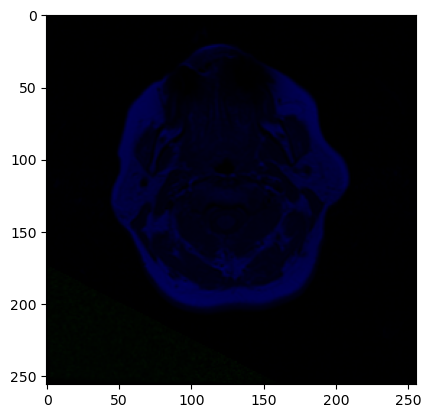

In [8]:
plt.imshow(cv2.imread(brain_df.image_path[20]))

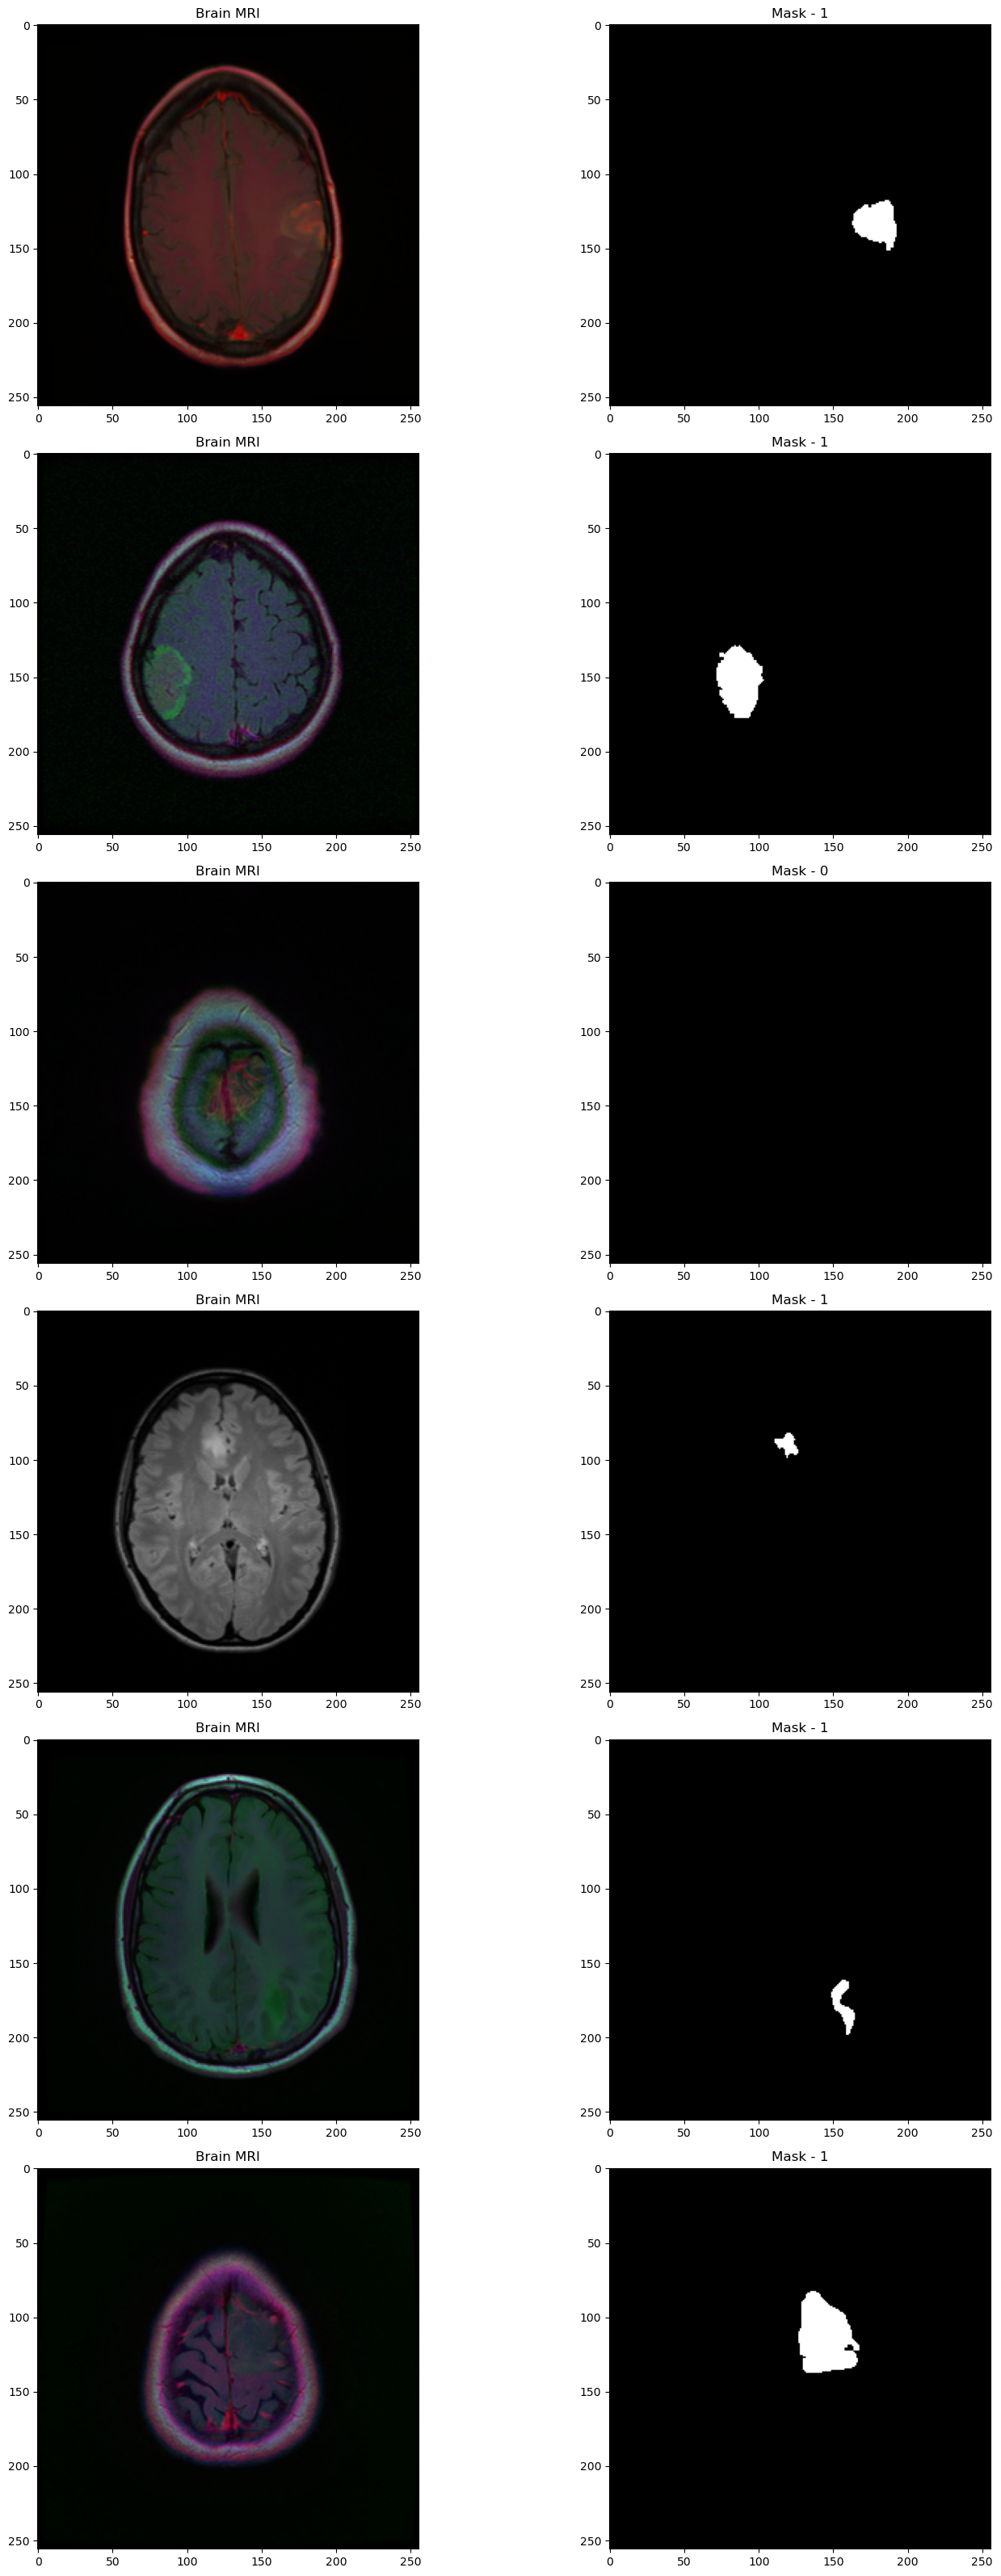

In [9]:
fig, axs = plt.subplots(6,2, figsize=(16,32))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df))
  axs[count][0].title.set_text("Brain MRI")
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) 
  axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i])) 
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i]))
  #axs[count][2].title.set_text("Brain MRI + Mask")
  count += 1

fig.tight_layout()

In [10]:
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.shape

(3929, 3)

In [11]:
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

In [12]:
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


### train_test_split():
1. It split arrays or matrices into random train and test subsets.
2. In the below case, **brain_df_train** is split into two section that is {train = 85%} and {test = 15%} 

In [13]:
train, test = train_test_split(brain_df_train, test_size = 0.15)

### ImageDataGenerator
1. Image data augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset.
2. Eg: Using one image we can create multiple variations of that image.
3. It include a range of operations from the field of image manipulation, such as shifts, flips, zooms, and much more.
4. In the below code we have created a data generator which scales the data from 0 to 1 and makes validation split of 0.15

In [14]:
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)

## Train Test and Validation
## In our case, Train = 85%, Test = 15% and Validate = 15%

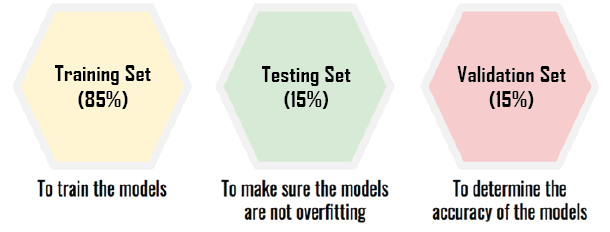

### flow_from_dataframe():
1. Takes the dataframe and the path to a directory + generates batches.
2. The generated batches contain augmented/normalized data.

**dataframe**: dataframe containing the filepaths relative to directory

**directory**: path to the directory to read images from

**x_col**: string, column in dataframe that contains the filenames

**y_col**: string or list, column/s in dataframe that has the target data.

**subset**: Training or Validation

**batch_size**: number of training examples utilized in one iteration (default: 32)

**shuffle**: whether to shuffle the data (default: True)

**class_mode**: Determines the type of label arrays that are returned

**target_size**: The dimensions to which all images found will be resized. (default:(256,256))

In [15]:
train_generator=datagen.flow_from_dataframe(
dataframe=train, 
directory= './', 
x_col='image_path', 
y_col='mask', 
subset="training",
batch_size=16, 
shuffle=True, 
class_mode="categorical", 
target_size=(256,256))

valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

# Create a data generator for test images
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='mask',
batch_size=16,
shuffle=False,
class_mode='categorical',
target_size=(256,256))

Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


### From the above Image Generation, we got -
1. **2839** validated images for validation
2. **500** validated images for training
3. **590** validated images for testing

## ResNet50 Model
1. ResNet50 is a variant of ResNet model which has 48 Convolution layers along with MaxPool and Average Pool layer.

2. It returns a **ResNet-50 network trained on the ImageNet data set.**

**weights**: 'Imagenet' (pre-training on ImageNet), or the path to the weights file to be loaded.

**include_top**: whether to include the fully-connected layer at the top of the network.

**input_tensor**: optional Keras tensor (i.e. output of layers.Input()) to use as image input for the model.

In [16]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

94765736/94765736 [==============================] - 14s 0us/step


In [17]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 64, 64, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 64, 64, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 32, 32, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 16, 16, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 8, 8, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 8, 8, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 8, 8, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 8, 8, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

### Freeze the base model

In [18]:
for layer in basemodel.layers:
    layer.trainable = False

### Transfer Learning Process

In [19]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
# headmodel = Dense(256, activation = "relu")(headmodel)
# headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 64, 64, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 64, 64, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 32, 32, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 16, 16, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 8, 8, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 8, 8, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 8, 8, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 8, 8, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [21]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

### ModelCheckPoint
It is used to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.

### EarlyStopping
1. Assuming the goal of a training is to minimize the loss.
2. Use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)

In [22]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="classifier-resnet-weights.hdf5", verbose=1, save_best_only=True)

### loss : val_loss and accuracy : val_accuracy
The two losses (both loss and val_loss) are decreasing and the tow acc (acc and val_acc) are increasing. So this indicates the modeling is trained in a good way. The val_acc is the measure of how good the predictions of your model are.

In [23]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 1, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])

177/177 [==============================] - ETA: 0s - loss: 0.7073 - accuracy: 0.6142
Epoch 1: val_loss improved from inf to 0.64742, saving model to classifier-resnet-weights.hdf5
177/177 [==============================] - 520s 3s/step - loss: 0.7073 - accuracy: 0.6142 - val_loss: 0.6474 - val_accuracy: 0.6734


In [24]:
model_json = model.to_json()
with open("classifier-resnet-model.json","w") as json_file:
  json_file.write(model_json)

### Loading pretrained model

In [25]:
with open('resnet-50-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('weights.hdf5')
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [26]:
test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

36/36 [==============================] - 87s 2s/step


In [27]:
test_predict.shape

(576, 2)

In [28]:
test_predict

array([[6.7603621e-13, 9.9999994e-01],
       [9.9999863e-01, 1.3039117e-06],
       [9.9996716e-01, 3.2738710e-05],
       ...,
       [9.9999994e-01, 4.0105363e-12],
       [3.4071021e-12, 9.9999994e-01],
       [9.9999994e-01, 5.1380314e-13]], dtype=float32)

### numpy.argmax() 
This function returns indices of the maximum values are returned along with the specified axis.

In [29]:
# Obtain the predicted class from the model prediction
predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [30]:
predict

array(['1', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '1', '1',
       '0', '0', '0', '1', '1', '0', '0', '0', '0', '1', '1', '0', '0',
       '0', '1', '1', '0', '1', '0', '1', '0', '0', '0', '1', '0', '1',
       '0', '0', '0', '1', '0', '0', '1', '0', '0', '0', '1', '1', '0',
       '0', '0', '1', '1', '0', '0', '0', '0', '1', '0', '0', '0', '0',
       '1', '1', '0', '0', '1', '0', '1', '0', '0', '0', '1', '0', '0',
       '0', '0', '1', '0', '1', '1', '0', '0', '0', '1', '1', '0', '1',
       '0', '0', '1', '0', '0', '1', '0', '1', '1', '1', '0', '0', '0',
       '1', '0', '1', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0',
       '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '1', '1',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0',
       '0', '0', '1', '0', '0', '0', '0', '1', '0', '1', '0', '0', '1',
       '0', '0', '0', '0', '0', '1', '1', '0', '1', '0', '1', '1', '0',
       '1', '0', '0', '0', '1', '0', '0', '0', '1', '0', '0', '0

In [31]:
# since we have used test generator, it limited the images to len(predict), due to batch size
original = np.asarray(test['mask'])[:len(predict)]
len(original)

576

In [32]:
# Obtain the accuracy of the model
accuracy = accuracy_score(original, predict)
accuracy

0.9826388888888888

#### We plotted a Confusion Matrix on test data set having around 580 Brain MRI images it predicted 190 MRI images are having brain tumor and 380 MRI images are not having brain tumor and some images were in false positive and false negative section.

<Axes: >

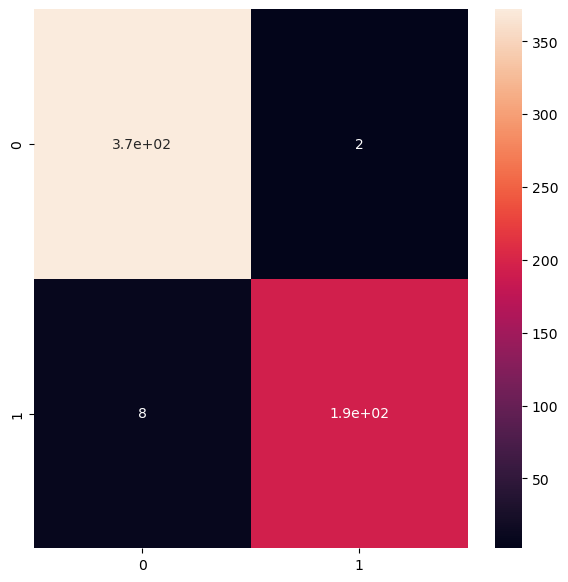

In [33]:
# plot the confusion matrix
cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

## PART II - ResUNet Segmentation Model

### Get the dataframe containing MRIs which have masks associated with them.

In [34]:
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 4)

### split the data into train and test data

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)

### create separate list for imageId, classId to pass into the generator

In [36]:
train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

#### Utilities file contains the code for custom loss function and custom data generator
#### The main feature of the utility is a function of recognizing the dependency between parent and son tables.

In [37]:
from utilities import DataGenerator

# create image generators
training_generator = DataGenerator(train_ids,train_mask)
validation_generator = DataGenerator(val_ids,val_mask)

In [38]:
def resblock(X, f):
  

  # make a copy of input
  X_copy = X

  # main path
  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X) 

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Short path
  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

### function to upscale and concatenate the values passsed

In [39]:
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [40]:
input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )

In [41]:
model_seg.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                           

 conv2d_10 (Conv2D)             (None, 32, 32, 128)  8320        ['max_pooling2d_2[0][0]']        
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 32, 32, 128)  512        ['conv2d_9[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 32, 32, 128)  512        ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_2 (Add)                    (None, 32, 32, 128)  0           ['batch_normalization_9[0][0]',  
                                                                  'batch_normalization_10[0][0]'] 
          

 batch_normalization_19 (BatchN  (None, 64, 64, 64)  256         ['conv2d_19[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_5 (Add)                    (None, 64, 64, 64)   0           ['batch_normalization_18[0][0]', 
                                                                  'batch_normalization_19[0][0]'] 
                                                                                                  
 activation_11 (Activation)     (None, 64, 64, 64)   0           ['add_5[0][0]']                  
                                                                                                  
 up_sampling2d_2 (UpSampling2D)  (None, 128, 128, 64  0          ['activation_11[0][0]']          
                                )                                                                 
          

In [42]:
from utilities import focal_tversky, tversky_loss, tversky

In [43]:
# Compile the model
adam = tf.keras.optimizers.Adam(learning_rate = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

#### use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
#### and save the best model with lower validation loss

In [44]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

checkpointer = ModelCheckpoint(filepath="ResUNet-weights.hdf5", verbose=1, save_best_only=True)

### save the model architecture to json file for future use

In [45]:
model_json = model_seg.to_json()
with open("ResUNet-model.json","w") as json_file:
  json_file.write(model_json)

In [46]:
from utilities import focal_tversky, tversky_loss, tversky

with open('ResUNet-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()

# load the model architecture 
model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights('weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

C:\Users\CHAITANYA\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [47]:
# Utilities file contains the code for custom loss function and custom data generator
from utilities import prediction

# making prediction
image_id, mask, has_mask = prediction(test, model, model_seg)

1/1 [==============================] - 0s 287ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 301ms/step


1/1 [==============================] - 0s 248ms/step


1/1 [==============================] - 0s 299ms/step


### creating a dataframe for the result

In [48]:
df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df_pred

image_path  \
0    TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_46...   
1    TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_4.tif   
2    TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_36...   
3    TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_10...   
4    TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_46...   
..                                                 ...   
585  TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_14...   
586  TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_3.tif   
587  TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_9.tif   
588  TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_21...   
589  TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_9.tif   

                                        predicted_mask  has_mask  
0    [[[[4.82039e-07], [1.7860841e-06], [3.700563e-...         1  
1                                              No mask         0  
2                                              No mask         0  
3                                              No mask         0  
4                                              No mask         0  
..                                                 ...       ...  
585  [[[[7.9019566e-07], [3.0612975e-06], [7.551538...         1  
586                                            No mask         0  
587                                            No mask         0  
588  [[[[7.618547e-07], [3.069158e-06], [7.378944e-...         1  
589                                            No mask         0  

[590 rows x 3 columns]

### Merge the dataframe containing predicted results with the original test data.

In [49]:
df_pred = test.merge(df_pred, on = 'image_path')
df_pred.head()

image_path  \
0  TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_46...   
1  TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_4.tif   
2  TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_36...   
3  TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_10...   
4  TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_46...   

                                           mask_path mask  \
0  TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_46...    1   
1  TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_4_...    0   
2  TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_36...    0   
3  TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_10...    0   
4  TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_46...    0   

                                      predicted_mask  has_mask  
0  [[[[4.82039e-07], [1.7860841e-06], [3.700563e-...         1  
1                                            No mask         0  
2                                            No mask         0  
3                                            No mask         0  
4                                            No mask         0

### Displaying the dataset with the output generated by the ResUNet Model

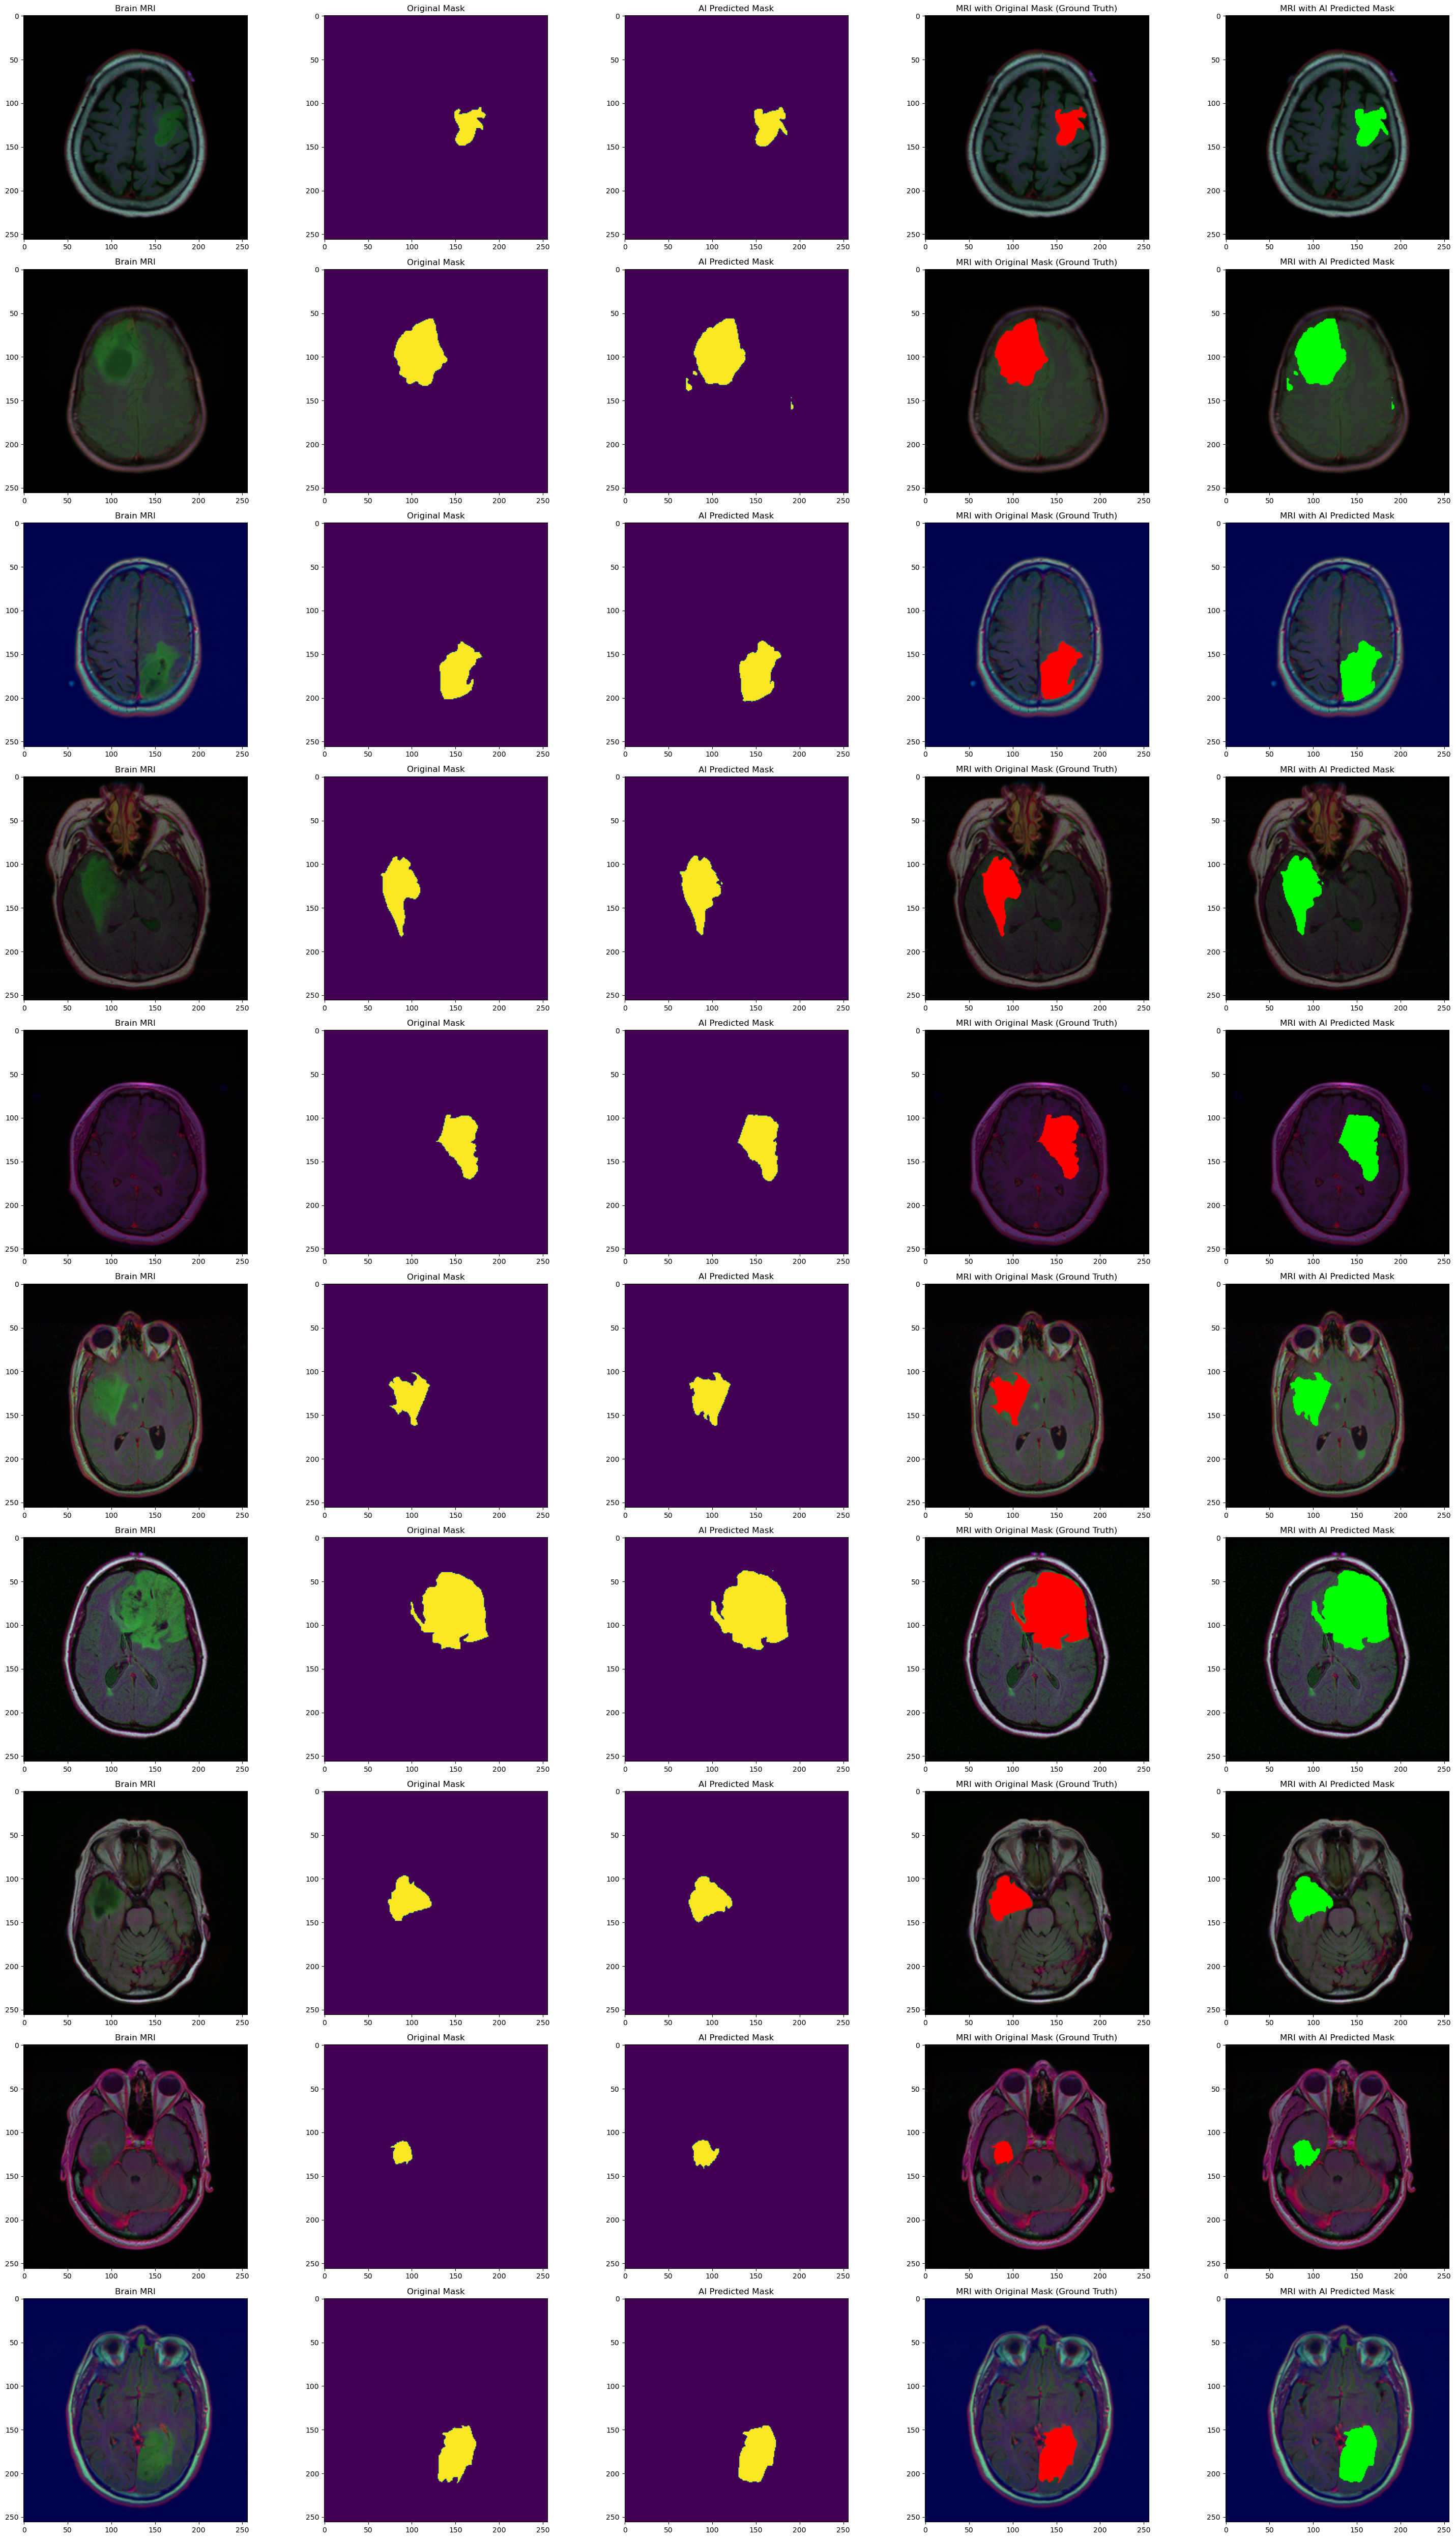

In [50]:
count = 0 
fig, axs = plt.subplots(10, 5, figsize=(30, 50))
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 10:
    # read the images and convert them to RGB format
    img = io.imread(df_pred.image_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # Obtain the mask for the image 
    mask = io.imread(df_pred.mask_path[i])
    axs[count][1].title.set_text("Original Mask")
    axs[count][1].imshow(mask)

    # Obtain the predicted mask for the image 
    predicted_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()
    axs[count][2].title.set_text("AI Predicted Mask")
    axs[count][2].imshow(predicted_mask)
    
    # Apply the mask to the image 'mask==255'
    img[mask == 255] = (255, 0, 0)
    axs[count][3].title.set_text("MRI with Original Mask (Ground Truth)")
    axs[count][3].imshow(img)

    img_ = io.imread(df_pred.image_path[i])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0, 255, 0)
    axs[count][4].title.set_text("MRI with AI Predicted Mask")
    axs[count][4].imshow(img_)
    count += 1

fig.tight_layout()

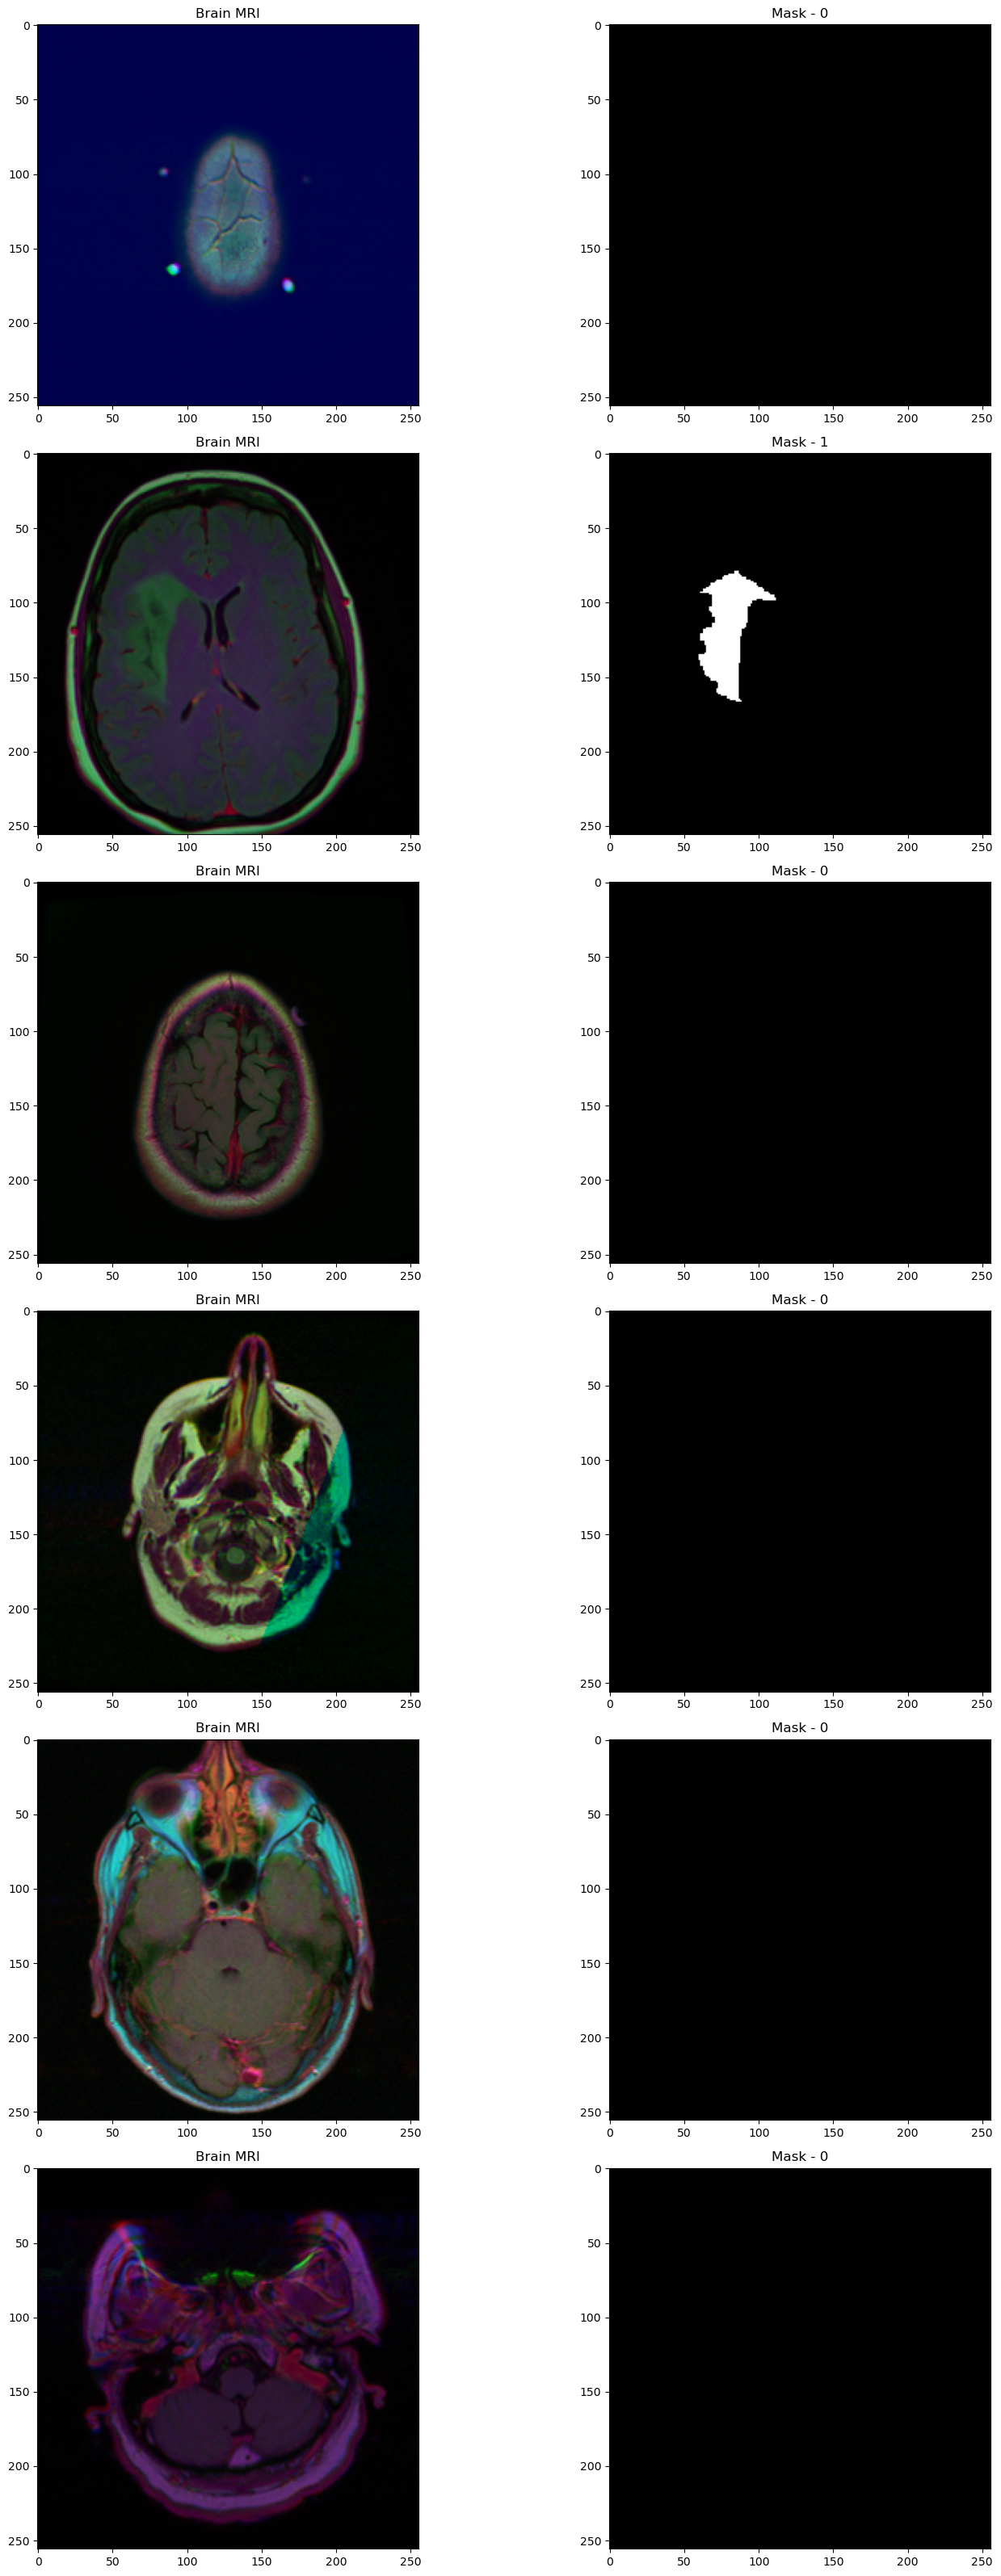

In [51]:
fig, axs = plt.subplots(6,2, figsize=(16,32))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df))
  axs[count][0].title.set_text("Brain MRI")
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) 
  axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i])) 
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i]))
  #axs[count][2].title.set_text("Brain MRI + Mask")
  count += 1

fig.tight_layout()